In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
from pathlib import Path
from nldi_xstool.ancillary import queryDEMsShape, getGageDatum
from nldi_xstool.nldi_xstool import getXSAtPoint, getXSAtEndPts
from shapely.geometry import LineString, Point
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
import requests
# import plotly.express as px
import folium
from folium import plugins
import time

from helpers import plotGageLocation, plotGageXS, interpTValues, plotGageXS_meas

In [2]:
file = Path('../data/01451500_6-29-21.csv')
print(file.exists())
data = pd.read_csv(file)
# data

True


In [3]:
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.lon_SPC, data.lat_SPC)) 
# Set crs to StatePlane Pennsylvania South
gdf = gdf.set_crs('ESRI:102729')
# Now set to geographic coordinates
gdf_geo = gdf.to_crs('epsg:4326')
gdf_geo

,lat_SPC,lon_SPC,measured_elevation,geometry
0,463054.999,2597917.029,267.519,POINT (-75.48369 40.58228)
1,463018.152,2598043.190,264.566,POINT (-75.48324 40.58217)
2,463054.999,2597917.029,9.747,POINT (-75.48369 40.58228)
3,463018.152,2598043.190,6.964,POINT (-75.48324 40.58217)
4,463049.039,2597987.673,6.956,POINT (-75.48344 40.58226)
5,463033.526,2598008.143,6.402,POINT (-75.48336 40.58222)
6,463019.655,2598026.716,6.289,POINT (-75.48330 40.58218)
7,463003.400,2598048.948,5.376,POINT (-75.48322 40.58213)
8,462992.515,2598061.812,0.984,POINT (-75.48317 40.58210)
9,462987.882,2598067.446,0.687,POINT (-75.48315 40.58209)


In [4]:
# gdf_geo

In [5]:
def distance(p1t, p2t):
    return np.sqrt(np.sum(np.square(np.array(p2t)-np.array(p1t))))
gdf_geo_ca = gdf_geo.to_crs("epsg:3857")
# del gdf_geo_ca['index']
gdf_geo_ca = gdf_geo_ca[4:32].reset_index()
gdf_geo_ca['station'] = 0.0
for index, v in gdf_geo_ca.iterrows():
    if index == 0:
        p1 = v.geometry
    gdf_geo_ca.at[index, 'station'] = float(distance(p1, v.geometry))
    
# gdf_geo_ca

In [6]:
gage_path = {'01451500': {'path': [(-75.48344, 40.58226), (-75.48275, 40.58186)], 
             'name': 'Little Lehigh Creek near Allentown, PA'}
            }

gage_thresholds = {'01451500': {'Thresholds': {1: {'Type':'Chord', 'Value': 7.173, 'Name': 'Chord', 
                                                   'lat': 40.58207, 'lon': -75.48294},
                                               2: {'Type':'Top Of Bank', 'Value': 3.833, 'Name': 'BANK',
                                                   'lat': 40.58164, 'lon': -75.48354},
                                               3: {'Type':'Road', 'Value': 9.274, 'Name': 'Park Drive',
                                                   'lat': 40.58157, 'lon': -75.48324},
                                               4: {'Type':'Bridge Deck', 'Value': 8.442, 'Name': 'Bridge Deck',
                                                   'lat': 40.58211, 'lon': -75.48301},
                                               5: {'Type':'Bank', 'Value': 5.398, 'Name': 'Top of bank',
                                                   'lat': 40.58213, 'lon': -75.48322},
                                               6: {'Type':'Parking Lot', 'Value': 7.354, 'Name': 'Parking Lot',
                                                   'lat': 40.58230, 'lon': -75.48328},
                                               7: {'Type':'Path', 'Value': 4.784, 'Name': 'Path',
                                                   'lat': 40.58247, 'lon': -75.48256},
                                               8: {'Type':'BM2', 'Value': 14.812, 'Name': 'BM2',
                                                   'lat': 40.58228, 'lon': -75.48369},
                                               9: {'Type':'BM1', 'Value': 11.859, 'Name': 'BM1',
                                                   'lat': 40.58217, 'lon': -75.48324},
                                               10: {'Type':'BM2A', 'Value': 9.747, 'Name': 'BM2A',
                                                   'lat': 40.58228, 'lon': -75.48369},
                                               11: {'Type':'BM1A', 'Value': 6.964, 'Name': 'BM1A',
                                                   'lat': 40.58217, 'lon': -75.48324}}},
                  }

In [7]:
gage_datum_m = []
gage_location = []
gage_comid = []
dem_res = []
dem = []
xs_bbox = []
cross_sections = []
for index, (k,v) in enumerate(gage_path.items()):

    gage_datum_m.append(getGageDatum(k, verbose=False))
    gage_location.append(NLDI().getfeature_byid('nwissite', f'USGS-{k}'))
    gage_comid.append(gage_location[index].comid.values.astype(int)[0])
    x = gage_location[index].geometry.x[0]
    y = gage_location[index].geometry.y[0]
    
    path = v['path']
    cross_sections.append(getXSAtEndPts(path, 101, res=1.0))
    lnst = []
    for pt in path:
        lnst.append(Point(pt[0], pt[1]))
    bbox = LineString(lnst).envelope.bounds
    dem_res.append(queryDEMsShape(bbox))
    # buffer below is a quick hack for now ~ 200m
    xs_bbox.append(LineString(lnst).envelope.buffer(.002))
    dem.append(py3dep.get_map("DEM", 
                              xs_bbox[index].bounds, 
                              resolution=1, 
                              geo_crs="epsg:4326", 
                              crs="epsg:4326"))
    print(k, x, y, gage_comid[index], gage_datum_m[index])

01451500 -75.48296028535643 40.58231926916905 4188011 77.025


In [8]:
gdf_geo_ca['measured_elevation_m'] = gage_datum_m[0] + (gdf_geo_ca['measured_elevation']*.3048)
# gdf_geo_ca

Available Resolution: res_1m:True, res_3m:True, res_10m:True, res_30m:True


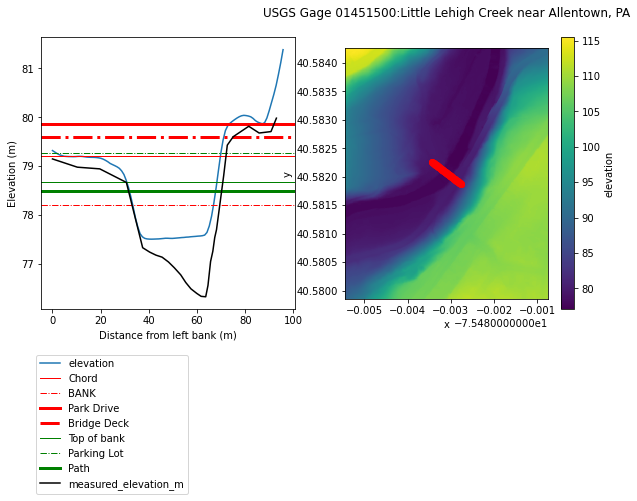

In [9]:
index = 0

m = plotGageLocation(index=index,
                       gage_location=gage_location,
                       gage_path=gage_path,
                       gage_thresholds=gage_thresholds,
                       cross_sections=cross_sections)

plotGageXS_meas(index=index,
             gage_path=gage_path,
             gage_thresholds=gage_thresholds,
             cross_sections=cross_sections,
             meas_xs=gdf_geo_ca,
             gage_datum=gage_datum_m,
             dem = dem,
             dem_res=dem_res,
             tindex=[0,1,2,3,4,5,6])
m

In [10]:
interpTValues(gage_path=gage_path,
              gage_thresholds=gage_thresholds,
              gage_datum_m=gage_datum_m,
              dem=dem)

Gage, Gage Name, Threshold Name, Threshold Value, DEM Interpolated Value, Difference
01451500,  Little Lehigh Creek near Allentown  PA,  Chord,  79.21133040000001,  78.07351564350341,  1.1378147564965957
01451500,  Little Lehigh Creek near Allentown  PA,  BANK,  78.1932984,  78.47336252621236,  -0.280064126212352
01451500,  Little Lehigh Creek near Allentown  PA,  Park Drive,  79.8517152,  80.12094760132193,  -0.26923240132192916
01451500,  Little Lehigh Creek near Allentown  PA,  Bridge Deck,  79.59812160000001,  77.59144512980517,  2.006676470194847
01451500,  Little Lehigh Creek near Allentown  PA,  Top of bank,  78.6703104,  78.65371625483102,  0.01659414516898039
01451500,  Little Lehigh Creek near Allentown  PA,  Parking Lot,  79.26649920000001,  79.46597545494892,  -0.1994762549489053
01451500,  Little Lehigh Creek near Allentown  PA,  Path,  78.4831632,  78.84461911172791,  -0.3614559117279015
01451500,  Little Lehigh Creek near Allentown  PA,  BM2,  81.53969760000001,  79.9865

Available Resolution: res_1m:True, res_3m:True, res_10m:True, res_30m:True


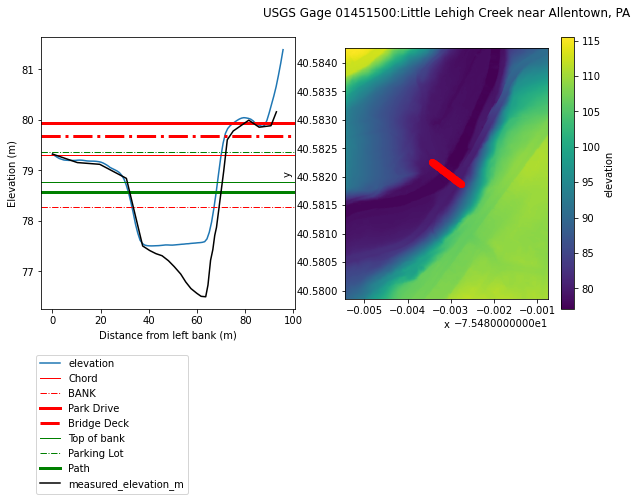

In [11]:
index = 0
offset = 0.087
gage_datum_m_o = gage_datum_m
gage_datum_m_o[0] = gage_datum_m_o[0]+0.087

gdf_geo_ca['measured_elevation_m'] = gage_datum_m[0] + (gdf_geo_ca['measured_elevation']*.3048) + offset
m = plotGageLocation(index=index,
                       gage_location=gage_location,
                       gage_path=gage_path,
                       gage_thresholds=gage_thresholds,
                       cross_sections=cross_sections)

plotGageXS_meas(index=index,
             gage_path=gage_path,
             gage_thresholds=gage_thresholds,
             cross_sections=cross_sections,
             meas_xs=gdf_geo_ca,
             gage_datum=gage_datum_m_o,
             dem = dem,
             dem_res=dem_res,
             tindex=[0,1,2,3,4,5,6])
m

In [12]:
gage_datum_m_o

[77.11200000000001]

In [13]:
gage_thresholds[0]

KeyError: 0